I've implemented the integral of wt in pearce. This notebook verifies it works as I believe it should. 

In [1]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Load up the tptY3 buzzard mocks. 

In [3]:
fname = '/u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits'
hdulist = fits.open(fname)

In [4]:
hdulist.info()

Filename: /u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1  xip         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  2  xim         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  3  gammat      BinTableHDU     32   400R x 5C   [K, K, K, D, D]   
  4  wtheta      BinTableHDU     32   300R x 5C   [K, K, K, D, D]   
  5  nz_shear_bpz  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  6  nz_shear_true  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  7  nz_pos_zrm  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   
  8  nz_pos_zspec  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   


In [5]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [6]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [7]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [8]:
print z

0.232741617357


This code load a particular snapshot and and a particular HOD model. In this case, 'redMagic' is the Zheng07 HOD with the f_c variable added in.

In [9]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a, particles = True)

In [10]:
cat.load_model(a, 'redMagic')

In [11]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0 = 100, Om0 = 0.3, Tcmb0=2.725)

In [12]:
#cat.cosmology = cosmo # set to the "standard" one
#cat.h = cat.cosmology.h

Take the zspec in our selected zbin to calculate the dN/dz distribution. The below cell calculate the redshift distribution prefactor

$$ W = \frac{2}{c}\int_0^{\infty} dz H(z) \left(\frac{dN}{dz} \right)^2 $$

In [13]:
hdulist[8].columns

ColDefs(
    name = 'Z_LOW'; format = 'D'
    name = 'Z_MID'; format = 'D'
    name = 'Z_HIGH'; format = 'D'
    name = 'BIN1'; format = 'D'
    name = 'BIN2'; format = 'D'
    name = 'BIN3'; format = 'D'
    name = 'BIN4'; format = 'D'
    name = 'BIN5'; format = 'D'
)

In [14]:
nz_zspec = hdulist[8]

zbin_edges = [row[0] for row in nz_zspec.data]
zbin_edges.append(nz_zspec.data[-1][2]) # add the last bin edge
zbin_edges = np.array(zbin_edges)
Nz =  np.array([row[2+zbin] for row in nz_zspec.data])
N_total = np.sum(Nz)
dNdz = Nz/N_total

In [15]:
W = cat.compute_wt_prefactor(zbin_edges, dNdz)

In [16]:
print W

0.00275848072207


If we happened to choose a model with assembly bias, set it to 0. Leave all parameters as their defaults, for now. 

In [17]:
params = cat.model.param_dict.copy()

params['mean_occupation_centrals_assembias_param1'] = 0
params['mean_occupation_satellites_assembias_param1'] = 0
params['logMmin'] = 11.95
params['sigma_logM'] = 0.2
params['f_c'] = 0.2
params['alpha'] = 1.21
params['logM1'] = 13.71
params['logM0'] = 11.39

print params

{'logM1': 13.71, 'mean_occupation_satellites_assembias_param1': 0, 'logMmin': 11.95, 'mean_occupation_centrals_assembias_param1': 0, 'f_c': 0.2, 'logM0': 11.39, 'sigma_logM': 0.2, 'alpha': 1.21}


In [18]:
cat.populate(params)

In [19]:
nd_cat =  cat.calc_analytic_nd()
print nd_cat

0.000416282370952


In [20]:
cat.cosmology

LambdaCDM(H0=70 km / (Mpc s), Om0=0.286, Ode0=0.714, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=None)

In [21]:
area = 4635.4 #sq degrees
full_sky = 41253 #sq degrees

volIn, volOut = cat.cosmology.comoving_volume(z_bins[zbin-1]), cat.cosmology.comoving_volume(z_bins[zbin])

fullsky_volume = volOut-volIn
survey_volume = fullsky_volume*area/full_sky
nd_mock = N_total/survey_volume
print nd_mock

0.000310787566755 1 / Mpc3


In [22]:
volIn.value, volOut

(1003707196.0549119, <Quantity 7202862177.90597 Mpc3>)

In [23]:
correct_nds = np.array([1e-3, 1e-3, 1e-3, 4e-4, 1e-4])

In [24]:
%%bash
ls ~jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_*vlim_area.fit

/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_highdens_0.5_vlim_area.fit
/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_higherlum_1.5_vlim_area.fit
/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_highlum_1.0_vlim_area.fit


In [25]:
vol_fname = '/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_highlum_1.0_vlim_area.fit'
vol_hdulist = fits.open(vol_fname)

In [26]:
nd_mock.value/nd_cat

0.74657873703409006

In [27]:
#compute the mean mass
mf = cat.calc_mf()
HOD = cat.calc_hod()
mass_bin_range = (9,16)
mass_bin_size = 0.01
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
print mean_host_mass

3.11158400873e+13


In [28]:
theta_bins = np.logspace(np.log10(2.5), np.log10(2000), 25)/60 #binning used in buzzard mocks
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [29]:
r_bins = np.logspace(-0.5, 1.7, 16)/cat.h
rpoints = (r_bins[1:]+r_bins[:-1])/2

In [30]:
r_bins

array([  0.45175395,   0.63324042,   0.88763679,   1.2442337 ,
         1.74408893,   2.44475472,   3.42690417,   4.8036198 ,
         6.73341362,   9.43847783,  13.23026754,  18.54536107,
        25.99572655,  36.43918262,  51.07816578,  71.59817623])

In [31]:
wt =  cat.calc_wt(theta_bins, r_bins, W)

In [32]:
wt

array([  5.14080089e-01,   3.83818606e-01,   2.79953289e-01,
         2.02534315e-01,   1.49157772e-01,   1.14547816e-01,
         9.16990924e-02,   7.42343164e-02,   5.95247700e-02,
         4.67826112e-02,   3.57983340e-02,   2.67508118e-02,
         1.91336493e-02,   1.26178022e-02,   7.37817573e-03,
         4.00763373e-03,   1.78555440e-03,   4.84179837e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [33]:
r_bins

array([  0.45175395,   0.63324042,   0.88763679,   1.2442337 ,
         1.74408893,   2.44475472,   3.42690417,   4.8036198 ,
         6.73341362,   9.43847783,  13.23026754,  18.54536107,
        25.99572655,  36.43918262,  51.07816578,  71.59817623])

Use my code's wrapper for halotools' xi calculator. Full source code can be found [here](https://github.com/mclaughlin6464/pearce/blob/31e2f6a3598217dcf1be3d2606b69c4e529fc791/pearce/mocks/cat.py#L688).

In [34]:
xi = cat.calc_xi(r_bins, do_jackknife=False)

Interpolate with a Gaussian process. May want to do something else "at scale", but this is quick for now. 

In [35]:
import george
from george.kernels import ExpSquaredKernel
kernel = ExpSquaredKernel(0.05)
gp = george.GP(kernel)
gp.compute(np.log10(rpoints))

In [36]:
print xi

[  2.26746621e+02   1.33194310e+02   7.10401872e+01   3.62165010e+01
   1.66876496e+01   7.38747353e+00   3.51012026e+00   1.95861311e+00
   1.15781675e+00   6.74287008e-01   3.75406275e-01   2.09398310e-01
   1.12162687e-01   5.37696058e-02   2.30823630e-02]


In [37]:
xi[xi<=0] = 1e-2 #ack

In [38]:
from scipy.stats import linregress
m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))

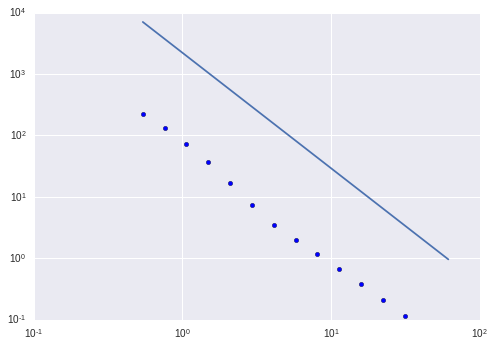

In [39]:
plt.plot(rpoints, (2.22353827e+03)*(rpoints**(-1.88359)))
#plt.plot(rpoints, b2*(rpoints**m2))

plt.scatter(rpoints, xi)
plt.loglog();

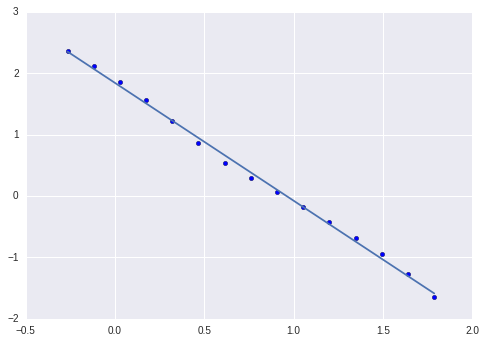

In [40]:
plt.plot(np.log10(rpoints), b+(np.log10(rpoints)*m))
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(np.log10(rpoints), np.log10(xi) )
#plt.loglog();

In [41]:
print m,b

-1.9182027746 1.84322362021


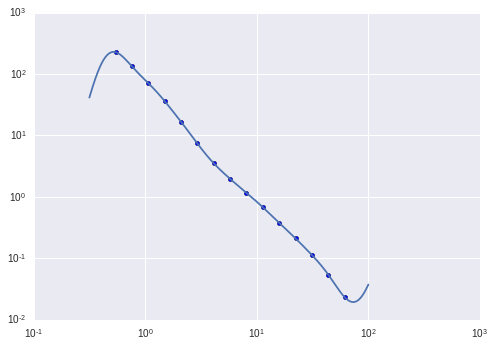

In [42]:
rpoints_dense = np.logspace(-0.5, 2, 500)

plt.scatter(rpoints, xi)
plt.plot(rpoints_dense, np.power(10, gp.predict(np.log10(xi), np.log10(rpoints_dense))[0]))
plt.loglog();

This plot looks bad on large scales. I will need to implement a linear bias model for larger scales; however I believe this is not the cause of this issue. The overly large correlation function at large scales if anything should increase w(theta). 

This plot shows the regimes of concern. The black lines show the value of r for u=0 in the below integral for each theta bin. The red lines show the maximum value of r for the integral I'm performing.

Perform the below integral in each theta bin:

$$ w(\theta) = W \int_0^\infty du \xi \left(r = \sqrt{u^2 + \bar{x}^2(z)\theta^2} \right) $$

Where $\bar{x}$ is the median comoving distance to z. 

In [43]:
print zbin

1


In [44]:
#a subset of the data from above. I've verified it's correct, but we can look again. 
zbin = 1
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))

The below plot shows the problem. There appears to be a constant multiplicative offset between the redmagic calculation and the one we just performed. The plot below it shows their ratio. It is near-constant, but there is some small radial trend. Whether or not it is significant is tough to say. 

In [45]:
from scipy.special import gamma
def wt_analytic(m,b,t,x):
    return W*b*np.sqrt(np.pi)*(t*x)**(1 + m)*(gamma(-(1./2) - m/2.)/(2*gamma(-(m/2.))) )

In [46]:
theta_bins_rm = np.logspace(np.log10(2.5), np.log10(250), 21)/60 #binning used in buzzard mocks
tpoints_rm = (theta_bins_rm[1:]+theta_bins_rm[:-1])/2

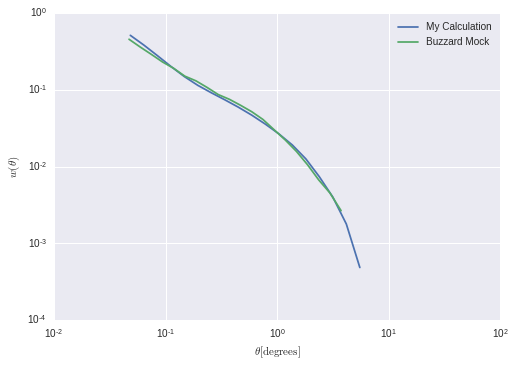

In [47]:
plt.plot(tpoints, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
#plt.plot(tpoints_rm, W.to("1/Mpc").value*mathematica_calc, label = 'Mathematica Calc')
#plt.plot(tpoints, wt_analytic(m,10**b, np.radians(tpoints), x),label = 'Mathematica Calc' )

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [48]:
print bias2

NameError: name 'bias2' is not defined

In [ ]:
plt.plot(rpoints, xi/xi_mm)
plt.plot(rpoints, cat.calc_bias(r_bins))
plt.plot(rpoints, bias2*np.ones_like(rpoints))
plt.xscale('log')

In [ ]:
plt.plot(rpoints, xi, label = 'Galaxy')
plt.plot(rpoints, xi_mm, label = 'Matter')
plt.loglog()
plt.legend(loc ='best')

In [ ]:
from astropy import units
from scipy.interpolate import interp1d

In [ ]:
cat.cosmology

In [ ]:
import pyccl as ccl
ob = 0.047
om = cat.cosmology.Om0
oc = om - ob
sigma_8 = 0.82
h = cat.h
ns = 0.96
cosmo = ccl.Cosmology(Omega_c =oc, Omega_b=ob, h=h, n_s=ns, sigma8=sigma_8 )

In [ ]:
big_rbins = np.logspace(1, 2.1, 21)
big_rbc = (big_rbins[1:] + big_rbins[:-1])/2.0
xi_mm2 = ccl.correlation_3d(cosmo, cat.a, big_rbc)

In [ ]:
plt.plot(rpoints, xi)
plt.plot(big_rbc, xi_mm2)
plt.vlines(30, 1e-3, 1e2)
plt.loglog()

In [ ]:
plt.plot(np.logspace(0,1.5, 20), xi_interp(np.log10(np.logspace(0,1.5,20))))
plt.plot(np.logspace(1.2,2.0, 20), xi_mm_interp(np.log10(np.logspace(1.2,2.0,20))))
plt.vlines(30, -3, 2)
#plt.loglog()
plt.xscale('log')

In [ ]:
xi_interp = interp1d(np.log10(rpoints), np.log10(xi))
xi_mm_interp = interp1d(np.log10(big_rbc), np.log10(xi_mm2))

print xi_interp(np.log10(30))/xi_mm_interp(np.log10(30))

In [ ]:

#xi = cat.calc_xi(r_bins)

xi_interp = interp1d(np.log10(rpoints), np.log10(xi))
xi_mm_interp = interp1d(np.log10(big_rbc), np.log10(xi_mm2))

#xi_mm = cat._xi_mm#self.calc_xi_mm(r_bins,n_cores='all')
#if precomputed, will just load the cache

bias2 = np.mean(xi[-3:]/xi_mm[-3:]) #estimate the large scale bias from the box
#print bias2
#note i don't use the bias builtin cuz i've already computed xi_gg. 

#Assume xi_mm doesn't go below 0; will fail catastrophically if it does. but if it does we can't hack around it.
#idx = -3
#m,b,_,_,_ =linregress(np.log10(rpoints), np.log10(xi))

#large_scale_model = lambda r: bias2*(10**b)*(r**m) #should i use np.power?
large_scale_model = lambda r: (10**b)*(r**m) #should i use np.power?

tpoints = (theta_bins[1:] + theta_bins[:-1])/2.0
wt_large = np.zeros_like(tpoints)
wt_small = np.zeros_like(tpoints)
x = cat.cosmology.comoving_distance(cat.z)*cat.a/cat.h

assert tpoints[0]*x.to("Mpc").value/cat.h >= r_bins[0]
        #ubins = np.linspace(10**-6, 10**4.0, 1001)
ubins = np.logspace(-6, 3.0, 1001)
ubc = (ubins[1:]+ubins[:-1])/2.0

def integrate_xi(bin_no):#, w_theta, bin_no, ubc, ubins) 
    int_xi = 0
    t_med = np.radians(tpoints[bin_no])
    for ubin_no, _u in enumerate(ubc):
        _du = ubins[ubin_no+1]-ubins[ubin_no]
        u = _u*units.Mpc*cat.a/cat.h
        du = _du*units.Mpc*cat.a/cat.h

        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h

        #if r > (units.Mpc)*cat.Lbox/10:
        try:
            int_xi+=du*bias2*(np.power(10, \
                        xi_mm_interp(np.log10(r.value)))) 
        except ValueError:
            int_xi+=du*0
        #else:
            #int_xi+=du*0#(np.power(10, \
                        #xi_interp(np.log10(r.value))))
    wt_large[bin_no] = int_xi.to("Mpc").value/cat.h

def integrate_xi_small(bin_no):#, w_theta, bin_no, ubc, ubins) 
    int_xi = 0
    t_med = np.radians(tpoints[bin_no])
    for ubin_no, _u in enumerate(ubc):
        _du = ubins[ubin_no+1]-ubins[ubin_no]
        u = _u*units.Mpc*cat.a/cat.h
        du = _du*units.Mpc*cat.a/cat.h

        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h

        #if r > (units.Mpc)*cat.Lbox/10:
        #int_xi+=du*large_scale_model(r.value)
        #else:
        try:
            int_xi+=du*(np.power(10, \
                        xi_interp(np.log10(r.value))))
        except ValueError:
            try:
                int_xi+=du*bias2*(np.power(10, \
                        xi_mm_interp(np.log10(r.value))))
            except ValueError:
                int_xi+=0*du
    wt_small[bin_no] = int_xi.to("Mpc").value/cat.h
#Currently this doesn't work cuz you can't pickle the integrate_xi function.
#I'll just ignore for now. This is why i'm making an emulator anyway
#p = Pool(n_cores)  
map(integrate_xi, range(tpoints.shape[0]));
map(integrate_xi_small, range(tpoints.shape[0]));

In [ ]:
#wt_large[wt_large<1e-10] = 0
wt_small[wt_small<1e-10] = 0

In [ ]:
wt_large

In [ ]:
plt.plot(tpoints, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
#plt.plot(tpoints, W*wt_large, label = 'LS')
plt.plot(tpoints, W*wt_small, label = "My Calculation")
#plt.plot(tpoints, wt+W*wt_large, label = "both")
#plt.plot(tpoints_rm, W.to("1/Mpc").value*mathematica_calc, label = 'Mathematica Calc')
#plt.plot(tpoints, wt_analytic(m,10**b, np.radians(tpoints), x),label = 'Mathematica Calc' )

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [ ]:
wt/wt_redmagic

In [ ]:
wt_redmagic/(W.to("1/Mpc").value*mathematica_calc)

In [ ]:
import cPickle as pickle
with open('/u/ki/jderose/ki23/bigbrother-addgals/bbout/buzzard-flock/buzzard-0/buzzard0_lb1050_xigg_ministry.pkl') as f:
    xi_rm = pickle.load(f)

In [ ]:
xi_rm.metrics[0].xi.shape

In [ ]:
xi_rm.metrics[0].mbins

In [ ]:
xi_rm.metrics[0].cbins

In [ ]:
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(rpoints, xi)
for i in xrange(3):
    for j in xrange(3):
        plt.plot(xi_rm.metrics[0].rbins[:-1], xi_rm.metrics[0].xi[:,i,j,0])
plt.loglog();

In [ ]:
plt.subplot(211)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
#plt.ylim([0,10])
plt.subplot(212)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
plt.ylim([2.0,4])

In [ ]:
xi_rm.metrics[0].xi.shape

In [ ]:
xi_rm.metrics[0].rbins #Mpc/h

The below cell calculates the integrals jointly instead of separately. It doesn't change the results significantly, but is quite slow. I've disabled it for that reason. 

In [ ]:
x = cat.cosmology.comoving_distance(z)*a
#ubins = np.linspace(10**-6, 10**2.0, 1001)
ubins = np.logspace(-6, 2.0, 51)
ubc = (ubins[1:]+ubins[:-1])/2.0

#NLL
def liklihood(params, wt_redmagic,x, tpoints):
    #print _params
    #prior  = np.array([ PRIORS[pname][0] < v < PRIORS[pname][1] for v,pname in zip(_params, param_names)])
    #print param_names
    #print prior
    #if not np.all(prior):
    #    return 1e9
    #params = {p:v for p,v in zip(param_names, _params)}
    #cat.populate(params)
    #nd_cat =  cat.calc_analytic_nd(parmas)
    #wt = np.zeros_like(tpoints_rm[:-5])
    
    #xi = cat.calc_xi(r_bins, do_jackknife=False)
    #m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))
    
    #if np.any(xi < 0):
    #    return 1e9
    #kernel = ExpSquaredKernel(0.05)
    #gp = george.GP(kernel)
    #gp.compute(np.log10(rpoints))
    
    #for bin_no, t_med in enumerate(np.radians(tpoints_rm[:-5])):
    #    int_xi = 0
    #    for ubin_no, _u in enumerate(ubc):
    #        _du = ubins[ubin_no+1]-ubins[ubin_no]
    #        u = _u*unit.Mpc*a
    #        du = _du*unit.Mpc*a
            #print np.sqrt(u**2+(x*t_med)**2)
    #        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h
            #if r > unit.Mpc*10**1.7: #ignore large scales. In the full implementation this will be a transition to a bias model. 
            #    int_xi+=du*0
            #else:
                # the GP predicts in log, so i predict in log and re-exponate
            #    int_xi+=du*(np.power(10, \
            #            gp.predict(np.log10(xi), np.log10(r.value), mean_only=True)[0]))
    #        int_xi+=du*(10**b)*(r.to("Mpc").value**m)

        #print (((int_xi*W))/wt_redmagic[0]).to("m/m")
        #break
    #    wt[bin_no] = int_xi*W.to("1/Mpc")
        
    wt = wt_analytic(params[0],params[1], tpoints, x.to("Mpc").value)   
    chi2 = np.sum(((wt - wt_redmagic[:-5])**2)/(1e-3*wt_redmagic[:-5]) )
    
    #chi2=0
    #print nd_cat
    #print wt
    #chi2+= ((nd_cat-nd_mock.value)**2)/(1e-6)
    
    #mf = cat.calc_mf()
    #HOD = cat.calc_hod()
    #mass_bin_range = (9,16)
    #mass_bin_size = 0.01
    #mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

    #mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
    #                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
        
    #chi2+=((13.35-np.log10(mean_host_mass))**2)/(0.2)
    print chi2
    return chi2 #nll

In [ ]:
print nd_mock
print wt_redmagic[:-5]

In [ ]:
import scipy.optimize as op

In [ ]:
results = op.minimize(liklihood, np.array([-2.2, 10**1.7]),(wt_redmagic,x, tpoints_rm[:-5]))

In [ ]:
results

In [ ]:
#plt.plot(tpoints_rm, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
plt.plot(tpoints_rm, wt_analytic(-1.88359, 2.22353827e+03,tpoints_rm, x.to("Mpc").value), label = 'Mathematica Calc')

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [ ]:
plt.plot(np.log10(rpoints), np.log10(2.22353827e+03)+(np.log10(rpoints)*(-1.88)))
plt.scatter(np.log10(rpoints), np.log10(xi) )


In [ ]:
np.array([v for v in params.values()])